In [1]:
# import libraries
import os
import sys
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler,StandardScaler
import xgboost as xgb
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
# disable warnings
import warnings
warnings.simplefilter("ignore")

# Data cleaning and preprocessing

In [2]:
# import excel file and spilt into variables
df = pd.read_excel('churn.xlsx')
x = df.drop(['customerID','Churn'],axis=1)
y = df['Churn']

In [3]:
# check data first 5 rows
df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [4]:
# check data see if any missing value and wrong data type
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
customerID          7043 non-null object
gender              7043 non-null object
SeniorCitizen       7043 non-null int64
Partner             7043 non-null object
Dependents          7043 non-null object
tenure              7043 non-null int64
PhoneService        7043 non-null object
MultipleLines       7043 non-null object
InternetService     7043 non-null object
OnlineSecurity      7043 non-null object
OnlineBackup        7043 non-null object
DeviceProtection    7043 non-null object
TechSupport         7043 non-null object
StreamingTV         7043 non-null object
StreamingMovies     7043 non-null object
Contract            7043 non-null object
PaperlessBilling    7043 non-null object
PaymentMethod       7043 non-null object
MonthlyCharges      7043 non-null float64
TotalCharges        7043 non-null object
Churn               7043 non-null object
dtypes: float64(1), int64(2), obj

In [5]:
# TotalCharges is a object data type, let's change to float64
x['TotalCharges'] = x['TotalCharges'].replace(' ',0)
x['TotalCharges']  = pd.to_numeric(x['TotalCharges'])

df['TotalCharges'] = df['TotalCharges'].replace(' ',0)
df['TotalCharges']  = pd.to_numeric(df['TotalCharges'])

In [6]:
for name in df.columns:
    print(name,df[name].unique())

customerID ['7590-VHVEG' '5575-GNVDE' '3668-QPYBK' ... '4801-JZAZL' '8361-LTMKD'
 '3186-AJIEK']
gender ['Female' 'Male']
SeniorCitizen [0 1]
Partner ['Yes' 'No']
Dependents ['No' 'Yes']
tenure [ 1 34  2 45  8 22 10 28 62 13 16 58 49 25 69 52 71 21 12 30 47 72 17 27
  5 46 11 70 63 43 15 60 18 66  9  3 31 50 64 56  7 42 35 48 29 65 38 68
 32 55 37 36 41  6  4 33 67 23 57 61 14 20 53 40 59 24 44 19 54 51 26  0
 39]
PhoneService ['No' 'Yes']
MultipleLines ['No phone service' 'No' 'Yes']
InternetService ['DSL' 'Fiber optic' 'No']
OnlineSecurity ['No' 'Yes' 'No internet service']
OnlineBackup ['Yes' 'No' 'No internet service']
DeviceProtection ['No' 'Yes' 'No internet service']
TechSupport ['No' 'Yes' 'No internet service']
StreamingTV ['No' 'Yes' 'No internet service']
StreamingMovies ['No' 'Yes' 'No internet service']
Contract ['Month-to-month' 'One year' 'Two year']
PaperlessBilling ['Yes' 'No']
PaymentMethod ['Electronic check' 'Mailed check' 'Bank transfer (automatic)'
 'Credit card (a

In [7]:
# add a feature to calcuate how many months each customer has stayed with same company
x['Contract_in_months'] = np.round(x['TotalCharges']/x['MonthlyCharges'],0).astype('int')
# drop the feature of contract
x.drop('Contract',axis=1,inplace=True)

In [8]:
# label encoding
def encoder(data):
    if data == 'Yes':
        data = 1
    elif data == 'No':
        data = 0
    return data

names = ['Partner','Dependents','PhoneService','PaperlessBilling']
for name in names:
    x[name] = x[name].apply(encoder)
# make a copy
x_copy = x.copy()

In [9]:
# Label Encoding and create dummy variables for non numeric data.
x = pd.get_dummies(x)
y = y.map({'Yes':1,'No':0})

In [10]:
# let's check the data again
x.head()

,SeniorCitizen,Partner,Dependents,tenure,PhoneService,PaperlessBilling,MonthlyCharges,TotalCharges,Contract_in_months,gender_Female,...,StreamingTV_No,StreamingTV_No internet service,StreamingTV_Yes,StreamingMovies_No,StreamingMovies_No internet service,StreamingMovies_Yes,PaymentMethod_Bank transfer (automatic),PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check
0,0,1,0,1,0,1,29.85,29.85,1,1,...,1,0,0,1,0,0,0,0,1,0
1,0,0,0,34,1,0,56.95,1889.50,33,0,...,1,0,0,1,0,0,0,0,0,1
2,0,0,0,2,1,1,53.85,108.15,2,0,...,1,0,0,1,0,0,0,0,0,1
3,0,0,0,45,0,0,42.30,1840.75,44,0,...,1,0,0,1,0,0,1,0,0,0
4,0,0,0,2,1,1,70.70,151.65,2,1,...,1,0,0,1,0,0,0,0,1,0


In [11]:
x.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 39 columns):
SeniorCitizen                              7043 non-null int64
Partner                                    7043 non-null int64
Dependents                                 7043 non-null int64
tenure                                     7043 non-null int64
PhoneService                               7043 non-null int64
PaperlessBilling                           7043 non-null int64
MonthlyCharges                             7043 non-null float64
TotalCharges                               7043 non-null float64
Contract_in_months                         7043 non-null int32
gender_Female                              7043 non-null uint8
gender_Male                                7043 non-null uint8
MultipleLines_No                           7043 non-null uint8
MultipleLines_No phone service             7043 non-null uint8
MultipleLines_Yes                          7043 non-null uint8
Interne

# Training the model

In [12]:
# split the data into train and test dataset
xtrain,xtest,ytrain,ytest = train_test_split(x,y,test_size=0.2,random_state=1)
scale = StandardScaler()
xtrain = scale.fit_transform(xtrain)
xtest = scale.transform(xtest)

In [13]:
boost = xgb.XGBClassifier(random_state=1).fit(xtrain,ytrain)
print(boost.score(xtest,ytest))
print(boost.score(xtrain,ytrain))
# model overfitting

0.7955997161107168
0.9311324103656372


Best parameter:  2
Test dataset score 0.809084
Train dataset score 0.816649


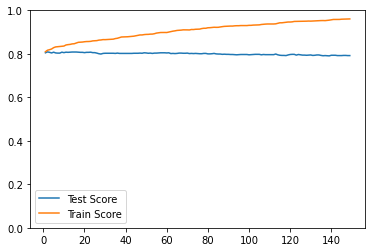

In [14]:
# tuning hyperparam of n_estimators
test = []
train = []
ranges = range(1,150)
for i in ranges:
    boost = xgb.XGBClassifier(random_state=1,n_estimators=i).fit(xtrain,ytrain)
    test.append(boost.score(xtest,ytest))
    train.append(boost.score(xtrain,ytrain))
plt.plot(ranges,test,label='Test Score')
plt.plot(ranges,train,label='Train Score')
plt.legend()
plt.ylim(0,1)
best_n_est = np.argmax(test)+1
print('Best parameter: ',best_n_est)
boost = xgb.XGBClassifier(random_state=1,n_estimators=best_n_est).fit(xtrain,ytrain)
print('Test dataset score',np.round(boost.score(xtest,ytest),6))

print('Train dataset score',np.round(boost.score(xtrain,ytrain),6))

Best parameter:  5
Test dataset score 0.809084
Train dataset score 0.807419


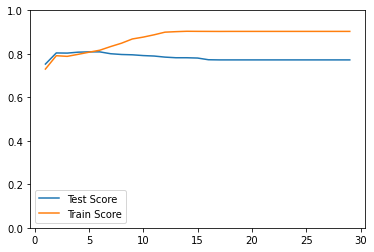

In [15]:
# tuning hyperparam of n_estimators
# the result is minor improved
test = []
train = []
ranges = range(1,30)
for i in ranges:
    boost = xgb.XGBClassifier(random_state=1,n_estimators=best_n_est,max_depth=i).fit(xtrain,ytrain)
    test.append(boost.score(xtest,ytest))
    train.append(boost.score(xtrain,ytrain))
plt.plot(ranges,test,label='Test Score')
plt.plot(ranges,train,label='Train Score')
plt.legend()
plt.ylim(0,1)
best_depth = np.argmax(test)+1
print('Best parameter: ',best_depth)
boost = xgb.XGBClassifier(random_state=1,n_estimators=best_n_est,max_depth=best_depth).fit(xtrain,ytrain)
print('Test dataset score',np.round(boost.score(xtest,ytest),6))
print('Train dataset score',np.round(boost.score(xtrain,ytrain),6))

In [16]:
# let s do more featur engineering
x_copy.head()

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Contract_in_months
0,Female,0,1,0,1,0,No phone service,DSL,No,Yes,No,No,No,No,1,Electronic check,29.85,29.85,1
1,Male,0,0,0,34,1,No,DSL,Yes,No,Yes,No,No,No,0,Mailed check,56.95,1889.50,33
2,Male,0,0,0,2,1,No,DSL,Yes,Yes,No,No,No,No,1,Mailed check,53.85,108.15,2
3,Male,0,0,0,45,0,No phone service,DSL,Yes,No,Yes,Yes,No,No,0,Bank transfer (automatic),42.30,1840.75,44
4,Female,0,0,0,2,1,No,Fiber optic,No,No,No,No,No,No,1,Electronic check,70.70,151.65,2


In [17]:
# check Contract_in_months is 0 and drop them
idx = x_copy[x_copy['Contract_in_months'] ==0].index
x_copy.drop(idx,axis=0,inplace=True)
print('Number of rows dorped: ',len(idx))
x_copy['Contract_in_months'].unique()
print(x_copy.shape)

Number of rows dorped:  11
(7032, 19)


In [18]:
for name in x_copy.columns:
    print(name,x_copy[name].unique())

gender ['Female' 'Male']
SeniorCitizen [0 1]
Partner [1 0]
Dependents [0 1]
tenure [ 1 34  2 45  8 22 10 28 62 13 16 58 49 25 69 52 71 21 12 30 47 72 17 27
  5 46 11 70 63 43 15 60 18 66  9  3 31 50 64 56  7 42 35 48 29 65 38 68
 32 55 37 36 41  6  4 33 67 23 57 61 14 20 53 40 59 24 44 19 54 51 26 39]
PhoneService [0 1]
MultipleLines ['No phone service' 'No' 'Yes']
InternetService ['DSL' 'Fiber optic' 'No']
OnlineSecurity ['No' 'Yes' 'No internet service']
OnlineBackup ['Yes' 'No' 'No internet service']
DeviceProtection ['No' 'Yes' 'No internet service']
TechSupport ['No' 'Yes' 'No internet service']
StreamingTV ['No' 'Yes' 'No internet service']
StreamingMovies ['No' 'Yes' 'No internet service']
PaperlessBilling [1 0]
PaymentMethod ['Electronic check' 'Mailed check' 'Bank transfer (automatic)'
 'Credit card (automatic)']
MonthlyCharges [29.85 56.95 53.85 ... 63.1  44.2  78.7 ]
TotalCharges [  29.85 1889.5   108.15 ...  346.45  306.6  6844.5 ]
Contract_in_months [ 1 33  2 44  8 22 10 2

In [19]:
x_copy.corr()['TotalCharges']
# Total charges have a high correlatin with tenure and Monthly Charges

SeniorCitizen         0.102411
Partner               0.319072
Dependents            0.064653
tenure                0.825880
PhoneService          0.113008
PaperlessBilling      0.157830
MonthlyCharges        0.651065
TotalCharges          1.000000
Contract_in_months    0.826248
Name: TotalCharges, dtype: float64

In [20]:
x_copy.corr()['MonthlyCharges']
# check with monthy charges, then drop feature of tenure
x_copy.drop('tenure',axis=1,inplace=True)

In [21]:
x_copy

,gender,SeniorCitizen,Partner,Dependents,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Contract_in_months
0,Female,0,1,0,0,No phone service,DSL,No,Yes,No,No,No,No,1,Electronic check,29.85,29.85,1
1,Male,0,0,0,1,No,DSL,Yes,No,Yes,No,No,No,0,Mailed check,56.95,1889.50,33
2,Male,0,0,0,1,No,DSL,Yes,Yes,No,No,No,No,1,Mailed check,53.85,108.15,2
3,Male,0,0,0,0,No phone service,DSL,Yes,No,Yes,Yes,No,No,0,Bank transfer (automatic),42.30,1840.75,44
4,Female,0,0,0,1,No,Fiber optic,No,No,No,No,No,No,1,Electronic check,70.70,151.65,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7038,Male,0,1,1,1,Yes,DSL,Yes,No,Yes,Yes,Yes,Yes,1,Mailed check,84.80,1990.50,23
7039,Female,0,1,1,1,Yes,Fiber optic,No,Yes,Yes,No,Yes,Yes,1,Credit card (automatic),103.20,7362.90,71
7040,Female,0,1,1,0,No phone service,DSL,Yes,No,No,No,No,No,1,Electronic check,29.60,346.45,12
7041,Male,1,1,0,1,Yes,Fiber optic,No,No,No,No,No,No,1,Mailed check,74.40,306.60,4


In [22]:
# for values in StreamingTV, Yes,No, No internet services.
# lets change those values into ordinal varbles and same to other features to have same values
names = ['OnlineSecurity','OnlineBackup','DeviceProtection','TechSupport','StreamingTV','StreamingMovies']
def encoding(data):
    if data =='Yes':
        data = 2
    if data == 'No':
        data = 1
    elif data =='No internet service':
        data = 0
    return data
for i in names:
    x_copy[i] = x_copy[i].apply(encoding)

In [23]:
for name in x_copy.columns:
    print(name,x_copy[name].unique())

gender ['Female' 'Male']
SeniorCitizen [0 1]
Partner [1 0]
Dependents [0 1]
PhoneService [0 1]
MultipleLines ['No phone service' 'No' 'Yes']
InternetService ['DSL' 'Fiber optic' 'No']
OnlineSecurity [1 2 0]
OnlineBackup [2 1 0]
DeviceProtection [1 2 0]
TechSupport [1 2 0]
StreamingTV [1 2 0]
StreamingMovies [1 2 0]
PaperlessBilling [1 0]
PaymentMethod ['Electronic check' 'Mailed check' 'Bank transfer (automatic)'
 'Credit card (automatic)']
MonthlyCharges [29.85 56.95 53.85 ... 63.1  44.2  78.7 ]
TotalCharges [  29.85 1889.5   108.15 ...  346.45  306.6  6844.5 ]
Contract_in_months [ 1 33  2 44  8 22 10 29 62 12 17 57 49 25 70 50 69 21 59 28 48 71 73  5
 47 11 20 61 13 46 53 66 43 14 60 18 63 65 36  9  3 32 64 56  7 42 51 30
 31 68 74 26 38  4 54 52 37 40 55 34 27 24 15  6 16 19 72 75 23 67 77 39
 58 35 41 45 76 79]


In [24]:
def encoding(data):
    if data =='Yes':
        data = 2
    if data == 'No':
        data = 1
    elif data =='No phone service':
        data = 0
    return data
x_copy['MultipleLines'] = x_copy['MultipleLines'].apply(encoding)

In [25]:
# lets create dummies variables and splite the dataset and train again
x_copy = pd.get_dummies(x_copy)
y_copy = y.copy()
y_copy.drop(idx,inplace=True,axis=0)
xtrain,xtest,ytrain,ytest = train_test_split(x_copy,y_copy,test_size=0.2,random_state=2)
scale = StandardScaler()
xtrain = scale.fit_transform(xtrain)
xtest = scale.transform(xtest)

In [26]:
boost = xgb.XGBClassifier(random_state=1).fit(xtrain,ytrain)
print(boost.score(xtest,ytest))
print(boost.score(xtrain,ytrain))

0.7803837953091685
0.9331555555555555


Best parameter:  19
Test dataset score 0.800995
Train dataset score 0.854578


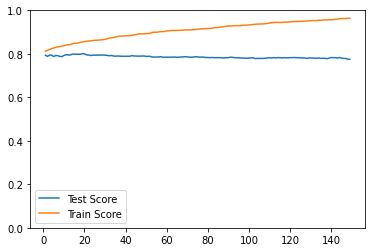

In [27]:
# tuning hyperparam of n_estimators
test = []
train = []
ranges = range(1,150)
for i in ranges:
    boost = xgb.XGBClassifier(random_state=1,n_estimators=i).fit(xtrain,ytrain)
    test.append(boost.score(xtest,ytest))
    train.append(boost.score(xtrain,ytrain))
plt.plot(ranges,test,label='Test Score')
plt.plot(ranges,train,label='Train Score')
plt.legend()
plt.ylim(0,1)
best_n_est = np.argmax(test)+1
print('Best parameter: ',best_n_est)
boost = xgb.XGBClassifier(random_state=1,n_estimators=best_n_est).fit(xtrain,ytrain)
print('Test dataset score',np.round(boost.score(xtest,ytest),6))

print('Train dataset score',np.round(boost.score(xtrain,ytrain),6))

Best parameter:  4
Test dataset score 0.803127
Train dataset score 0.820444


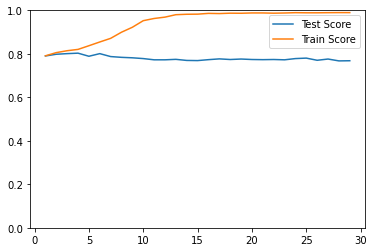

In [28]:
# tuning hyperparam of n_estimators
# the result is minor improved
test = []
train = []
ranges = range(1,30)
for i in ranges:
    boost = xgb.XGBClassifier(random_state=1,n_estimators=best_n_est,max_depth=i).fit(xtrain,ytrain)
    test.append(boost.score(xtest,ytest))
    train.append(boost.score(xtrain,ytrain))
plt.plot(ranges,test,label='Test Score')
plt.plot(ranges,train,label='Train Score')
plt.legend()
plt.ylim(0,1)
best_depth = np.argmax(test)+1
print('Best parameter: ',best_depth)
boost = xgb.XGBClassifier(random_state=1,n_estimators=best_n_est,max_depth=best_depth).fit(xtrain,ytrain)
print('Test dataset score',np.round(boost.score(xtest,ytest),6))
print('Train dataset score',np.round(boost.score(xtrain,ytrain),6))

# Exploratory data analysis

In [29]:
# create a plot function
def churn(column):
    plt.figure(figsize=(10,5))
    print(column)
    for i in range(len((df[column].unique()))):
        for row,num in zip(df[column].unique(),range(len(df[column].unique()))):
            cc = df[df[column] == df[column].unique()[i]]
            plt.subplot(1,len(df[column].unique()),i+1)
            plt.title(df[column].unique()[i])
            sns.countplot(cc['Churn'])        

In [30]:
# drop the customerID column because it is irrelevant to analysis 
df = df.drop('customerID',axis=1)
df.head()

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.50,No
2,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,Male,0,No,No,45,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,Female,0,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [31]:
# change the value in SeniorCitizen to text which is easier to analysis
df['SeniorCitizen'] = df['SeniorCitizen'].map({0:'Yes',1:'No'})
df.head()

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,Female,Yes,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,Male,Yes,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.50,No
2,Male,Yes,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,Male,Yes,No,No,45,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,Female,Yes,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


Contract


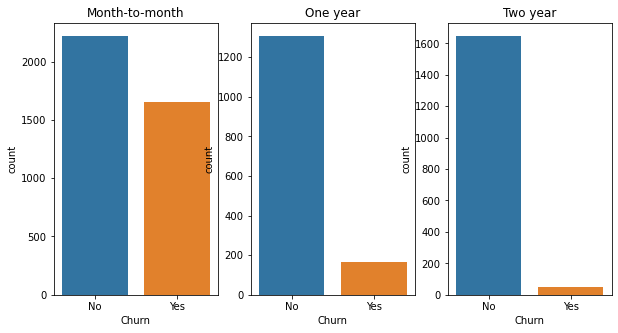

In [32]:
churn('Contract')
# Clearly see that the Month-to-month contract with higher churn rate, which means  customers are more likely to jump to
# other company with month-to-month contract. 
# One year and two year contract have relatively small churn rate, this is why tele companies want customer to sign fixed 
# contract

PaymentMethod


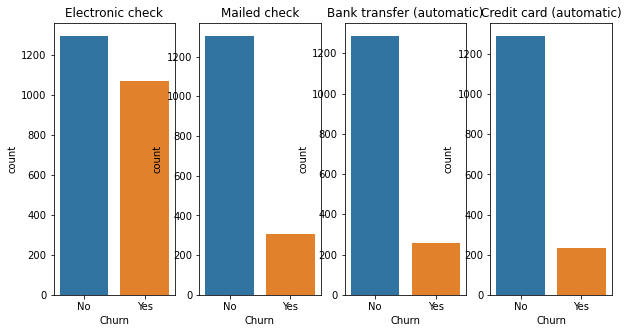

In [33]:
churn('PaymentMethod')
# The payment method is also a important fector as we can see that more than 1000 customer churned by using electronic check.
# So it is very important to have very convenient way for customers to pay their bill e.g. direct debit on credit card

PaperlessBilling


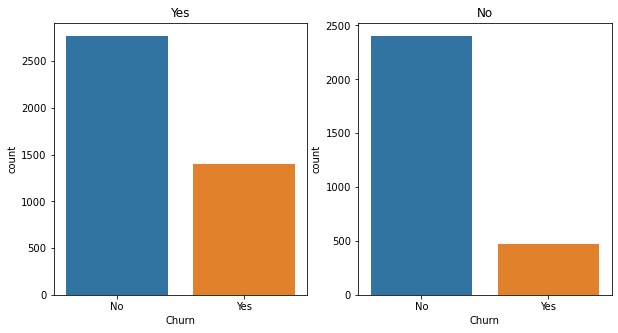

In [34]:
churn('PaperlessBilling')
# In this dataset, more people perfer to use paper bill so let's find out the reason

In [35]:
# this is the properly reason why more people perfer to use paper bill for not churned
number_of_senior = len((df[df['SeniorCitizen'] == 'Yes']))
print('number of Senior Citizens: {}'.format(number_of_senior))
print('number of young Citizens: {}'.format(len(df) - number_of_senior))

number of Senior Citizens: 5901
number of young Citizens: 1142


Averga monthly bill for young adults: 79.82
Averga monthly bill for seniors: 61.85


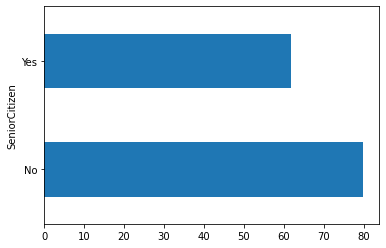

In [36]:
# let's explore more about how much average monthly bill for young adults and seniors
df.groupby('SeniorCitizen').mean()['MonthlyCharges'].plot(kind='barh')
young = df.groupby('SeniorCitizen')['MonthlyCharges'].mean().values[0]
senior = df.groupby('SeniorCitizen')['MonthlyCharges'].mean().values[1]
print('Averga monthly bill for young adults: {:.2f}'.format(young))
print('Averga monthly bill for seniors: {:.2f}'.format(senior))

bins


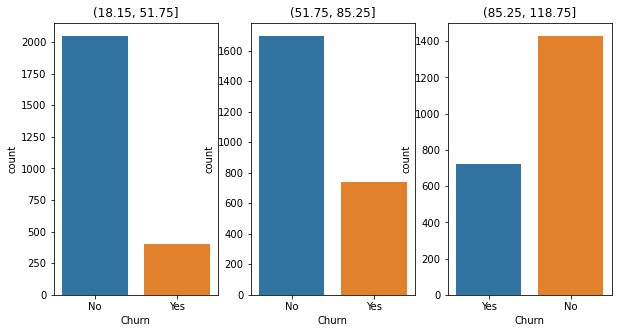

In [37]:
# let's cut the monthly charges in different range to see which range get the lowest churn rate
# it is reasonable to see that the low price will more likely to retain the customer
# when the monthly bill charges more than $85.25, customer will more likely to churn to seek better deal
bins = pd.cut(df['MonthlyCharges'],3)
df['bins'] = bins
churn('bins')

In [38]:
# let's see contract type compare to average monthly bill price
# The two year contract has lowest churn rate and also with lowest monthly price
df.groupby('Contract')['MonthlyCharges'].mean()

Contract
Month-to-month    66.398490
One year          65.048608
Two year          60.770413
Name: MonthlyCharges, dtype: float64

In [39]:
# let's see contract type compare to highest monthly bill price
df.groupby('Contract')['MonthlyCharges'].max()

Contract
Month-to-month    117.45
One year          118.60
Two year          118.75
Name: MonthlyCharges, dtype: float64

In [40]:
# let's see contract type compare to lowest monthly bill price
df.groupby('Contract')['MonthlyCharges'].min()

Contract
Month-to-month    18.75
One year          18.25
Two year          18.40
Name: MonthlyCharges, dtype: float64

OnlineBackup


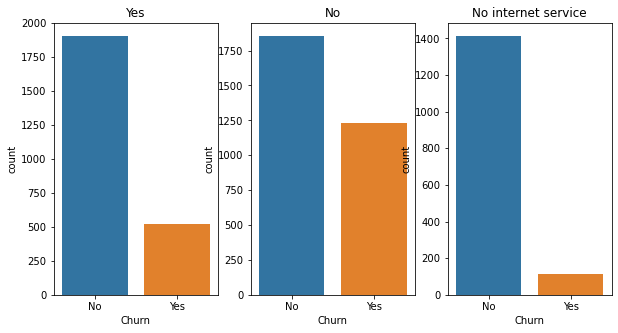

In [41]:
# let's check see if additional services provided to customers can reduce churn rate
churn('OnlineBackup')

DeviceProtection


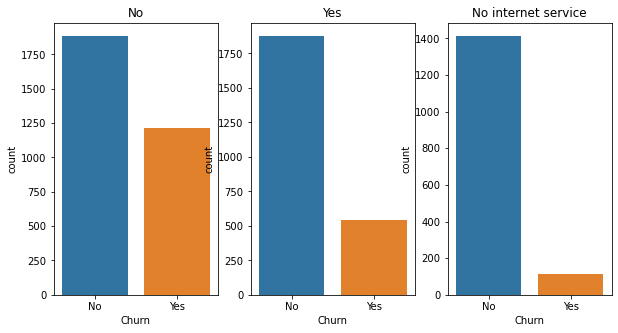

In [42]:
churn('DeviceProtection')

TechSupport


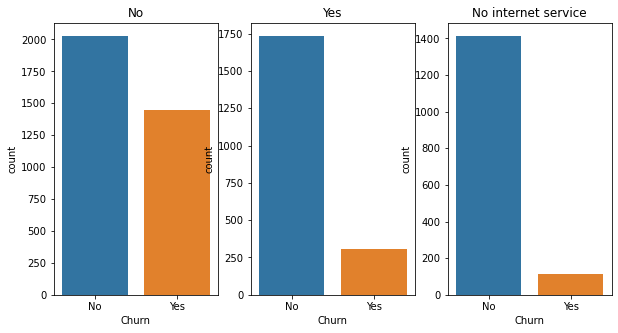

In [43]:
# we can see that companes should provide more serivces to customers in order to gain competition advanage, 
# otherwises it will they will have low customer retention rate.
churn('TechSupport')

gender


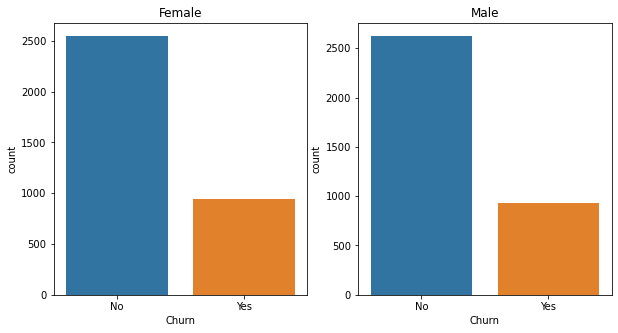

In [44]:
# check gender 
# gender is not an important factor for churning, because this is no much difference.
churn('gender')